In [1]:
import torch
from torchdiffeq import odeint
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import MaxNLocator
import seaborn as sns
sns.set(style="darkgrid", palette="muted", font="serif")
plt.rcParams.update(plt.rcParamsDefault)
import pickle
import pandas as pd

from abc import ABC, abstractmethod
import time, random, itertools
from typing import Callable, Tuple, List, Optional
from scipy.integrate import solve_ivp
from scipy.interpolate import RegularGridInterpolator
import tqdm

from scripts.utils import set_seed
from scripts.ds_class import *
from scripts.homeos import *
from scripts.plotting import *
from scripts.fit_motif import *
from scripts.time_series import *
from scripts.ra import *
plt.rcParams['xtick.labelsize'], plt.rcParams['ytick.labelsize'] = 14,14  
plt.rcParams["font.family"] = "serif"
mpl.rcParams['pdf.fonttype'] = 42  # Use TrueType fonts (editable in Illustrator)
mpl.rcParams['ps.fonttype'] = 42   # Same for EPS
mpl.rcParams['svg.fonttype'] = 'none'  # Keep text as text in SVG
set_seed(313)

In [2]:
#centering and scaling
def normalize_scale_pair(trajectories_target_full, training_pairs=False):
    # Compute mean and std for normalization
    mean = trajectories_target_full.mean(dim=(0, 1), keepdim=True)
    std = trajectories_target_full.std(dim=(0, 1), keepdim=True)

    # Apply normalization
    trajectories_target_full = (trajectories_target_full - mean) / std

    if training_pairs:
        # Generate training pairs
        trajectories_target = make_transition_pairs(trajectories_target_full)
    else:
        # Use full trajectories
        trajectories_target = trajectories_target_full.clone()
    
    return trajectories_target_full, trajectories_target, mean, std

In [3]:
set_seed(313)
dim = 2
homeo_type = 'node'
layer_sizes = 1*[128]
homeo_mean = 0.02  #0.02
homeo_std = 0.5 #0.25
target_homeo_params = {'homeo_type': homeo_type, 'dim': 2, 'layer_sizes': layer_sizes, 'init_type': 'small', 'activation': nn.ReLU, 'init_mean': homeo_mean, 'init_std': homeo_std}
#target_homeo_params = {'homeo_type': homeo_type, 'dim': 2, 'layer_sizes': layer_sizes, 'init_type': 'scaled', 'activation': nn.ReLU, 'init_mean': homeo_mean, 'init_std': homeo_std}
target_homeo = build_homeomorphism(target_homeo_params)

id_homeo_params = {'homeo_type': homeo_type, 'dim': 2, 'layer_sizes': layer_sizes, 'activation': nn.ReLU, 'init_type': 'identity'}
id_homeo = build_homeomorphism(id_homeo_params)

dt=.2
time_span = torch.tensor([0.0, 2.]) 
train_ratio = 0.8
simulation_params = {'initial_conditions_mode': 'random', 'number_of_target_trajectories': 50, 'time_span': time_span, 'dt': dt, 'noise_std': .0,
                     'training_pairs': False, 'margin': 0.5, 'seed': 42, 'train_ratio': train_ratio}
generator_ra = AnalyticalRingAttractor(dim=dim, dt=dt, time_span=time_span) 
# generator_ra = LearnableNDRingAttractor(dim=dim, dt=dt, time_span=time_span, noise_std=simulation_params['noise_std'])
init_conds = prepare_initial_conditions(mode=simulation_params['initial_conditions_mode'], num_points=simulation_params['number_of_target_trajectories'], margin=simulation_params['margin'], seed=simulation_params['seed'])
ra_trajs = generator_ra.compute_trajectory(torch.tensor(init_conds, dtype=torch.float32))
trajectories_target_full = target_homeo(ra_trajs)
trajectories_target_full, trajectories_target, mean, std = normalize_scale_pair(trajectories_target_full, simulation_params['training_pairs'])

N = trajectories_target_full.shape[0]
n_train = int(train_ratio * N)
n_test = N - n_train
train_set, test_set = random_split(trajectories_target_full, [n_train, n_test])
trajectories_target_train = trajectories_target[train_set.indices]
trajectories_target_test = trajectories_target[test_set.indices]
trajectories_target_train.shape

torch.Size([40, 10, 2])

In [5]:
# fig, ax = plt.subplots(figsize=(5, 5))

# for alpha in np.linspace(0, .99, 2):
#     interpolated_homeo = rescale_node_vf(target_homeo, alpha)
#     trajectories_target_full = interpolated_homeo(ra_trajs)
#     trajectories_target_full, trajectories_target, mean, std = normalize_scale_pair(trajectories_target_full, simulation_params['training_pairs'])
#     train_set, test_set = random_split(trajectories_target_full, [n_train, n_test])
#     trajectories_target_train = trajectories_target[train_set.indices]
#     trajectories_target_test = trajectories_target[test_set.indices]
#     for i in range(trajectories_target.shape[0]):
#         ax.plot(trajectories_target[i, :, 0].detach().numpy(), trajectories_target[i, :, 1].detach().numpy(), 'k-+', lw=2, alpha=0.5)
# plt.show()

In [63]:
homeo_type = 'node'
layer_sizes = 1*[64]
init_type = 'small'
homeo_params = {'homeo_type': homeo_type, 'dim': dim, 'layer_sizes': layer_sizes, 'activation': nn.ReLU} #, 'init_type': init_type}
homeo_lc = build_homeomorphism(homeo_params)

ds_motif = 'ring' #'lc', 'bla', 'stable', 'square',  
analytic = True
vf_on_ring_enabled = False #if analytic then not used
alpha_init = None
if simulation_params['training_pairs']:
    time_span = torch.tensor([0.0, dt])
ds_params = {'ds_motif': ds_motif, 'dim': dim, 'dt': dt, 'time_span': time_span, 'analytic': analytic, 'vf_on_ring_enabled': vf_on_ring_enabled, 'alpha_init': alpha_init}
source_system_ra = build_ds_motif(**ds_params)
homeo_ds_net = Homeo_DS_Net(homeo_lc, source_system_ra)

lr = 0.01
num_epochs = 500
annealing_params = {'dynamic': False, 'initial_std': .0, 'final_std': 0.}
training_params = {'lr': lr, 'num_epochs': num_epochs, 'annealing_params': annealing_params, 'early_stopping_patience': 1000, "batch_size": 32,
                   'use_inverse_formulation': True}

homeo_ds_net = train_homeo_ds_net_batched(homeo_ds_net=homeo_ds_net, trajectories_target=trajectories_target_train, **training_params)
homeo_ds_net.training_params = training_params
homeo_ds_net.ds_params = ds_params
homeo_ds_net.homeo_params = homeo_params
homeo_ds_net.eval();
#save_homeo_ds_net(homeo_ds_networks[0], f"model_pnorm{norm}_irn_.pth")

Epoch 0, log(Loss)= -1.0341
Epoch 10, log(Loss)= -1.3924
Epoch 20, log(Loss)= -1.6418
Epoch 30, log(Loss)= -1.6452
Epoch 40, log(Loss)= -1.4630
Epoch 50, log(Loss)= -1.7133


KeyboardInterrupt: 

Train loss: -2.0530071512891497 Test loss: -1.6937151295513455 Jacobian norm: 0.6803928017616272


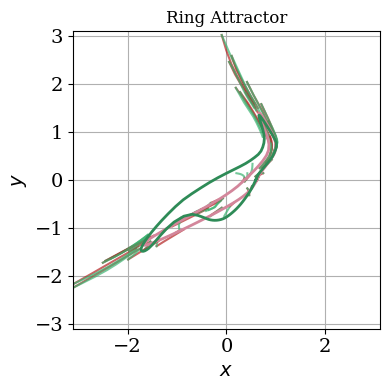

In [ ]:
plot_first_n = simulation_params['number_of_target_trajectories']
jac_norm = jacobian_norm_over_batch(homeo_ds_net.homeo_network, trajectories_target.reshape(-1,dim))
homeo_ds_net.jac_norm = jac_norm
trajectories_source, transformed_trajectories, test_loss = test_single_homeo_ds_net(homeo_ds_net=homeo_ds_net, trajectories_target=trajectories_target_test)
trajectories_source, transformed_trajectories, train_loss = test_single_homeo_ds_net(homeo_ds_net=homeo_ds_net, trajectories_target=trajectories_target)
fit_ra_points = get_homeo_invman(homeo_ds_net.homeo_network)
target_ra_points = get_homeo_invman(interpolated_homeo)
target_ra_points = (target_ra_points - mean.detach().numpy()) / std.detach().numpy() 
print(f"Train loss: {np.log10(train_loss)}", f"Test loss: {np.log10(test_loss)}", f"Jacobian norm: {jac_norm}")
plot_single_motif_trajectories(trajectories_source=trajectories_source, transformed_trajectories=transformed_trajectories, trajectories_target=trajectories_target_full.detach().numpy(), num_points=plot_first_n, which_axis='second', 
                            asymptotic_source_transformed=fit_ra_points, asymptotic_target=target_ra_points[0], bounds='from_targ_traj', 
                            source_name='Ring Attractor', show_fig=True,save_name=f"figures/ring_perthom.pdf")

In [ ]:

def perthomeo_exp():
    save_dir = "experiments/homeopert_ring"
    set_seed(313)
    homeo_type = 'node'
    layer_sizes = 1*[128]
    homeo_mean = 0.02  #0.02
    homeo_std = 0.5 #0.25
    dim=2
    target_homeo_params = {'homeo_type': homeo_type, 'dim': dim, 'layer_sizes': layer_sizes, 'init_type': 'small', 'activation': nn.ReLU, 'init_mean': homeo_mean, 'init_std': homeo_std}
    target_homeo = build_homeomorphism(target_homeo_params)
    save_homeo_ds_net(target_homeo, f"{save_dir}/target_homeo.pth")

    dt=.2
    time_span = torch.tensor([0.0, 2.]) 
    train_ratio = 0.8
    ds_motif = 'ring' 
    analytic = True
    vf_on_ring_enabled = True #if analytic then not used
    training_pairs = False
    alpha_init = None
    if training_pairs:
        time_span = torch.tensor([0.0, dt])
    ds_params = {'ds_motif': ds_motif, 'dim': dim, 'dt': dt, 'time_span': time_span, 'analytic': analytic, 'vf_on_ring_enabled': vf_on_ring_enabled, 'alpha_init': alpha_init}
    simulation_params = {'initial_conditions_mode': 'random', 'number_of_target_trajectories': 50, 'time_span': time_span, 'dt': dt, 'noise_std': .0,
                        'training_pairs': training_pairs, 'margin': 0.5, 'seed': 42, 'train_ratio': train_ratio, 'ds_params': ds_params}
    
    homeo_type = 'node'
    layer_sizes = 1*[128]
    init_type = None
    homeo_params = {'homeo_type': homeo_type, 'dim': dim, 'layer_sizes': layer_sizes, 'activation': nn.ReLU, 'init_type': init_type}

    lr = 0.01
    num_epochs = 1000
    annealing_params = {'dynamic': False, 'initial_std': .0, 'final_std': 0.}
    training_params = {'lr': lr, 'num_epochs': num_epochs, 'annealing_params': annealing_params, 'early_stopping_patience': 1000, "batch_size": 32,
                    'use_inverse_formulation': True}
    
    all_parameters = {'target_homeo_params': target_homeo_params, 'homeo_params': homeo_params, 'training_params': training_params, 'simulation_params': simulation_params}
    with open("parameters.pkl", "wb") as f:
        pickle.dump(all_parameters, f)
    
    # generate ring attractor trajectories
    generator_ra = AnalyticalRingAttractor(dim=dim, dt=dt, time_span=time_span) 
    # generator_ra = LearnableNDRingAttractor(dim=dim, dt=dt, time_span=time_span, noise_std=simulation_params['noise_std'])
    init_conds = prepare_initial_conditions(mode=simulation_params['initial_conditions_mode'], num_points=simulation_params['number_of_target_trajectories'], margin=simulation_params['margin'], seed=simulation_params['seed'])
    ra_trajs = generator_ra.compute_trajectory(torch.tensor(init_conds, dtype=torch.float32))

    B = ra_trajs.shape[0]
    n_train = int(train_ratio * B)
    n_test = B - n_train

    results = []
    for interpol_value_i, interpol_value in enumerate(np.linspace(0, 1, 11)):
        interpol_value = round(interpol_value, 2)
        print(f"Interpol value: {interpol_value}")

        interpolated_homeo = rescale_node_vf(target_homeo, interpol_value)
        trajectories_target_full = interpolated_homeo(ra_trajs)
        trajectories_target_full, trajectories_target, mean, std = normalize_scale_pair(trajectories_target_full, simulation_params['training_pairs'])
        np.save(f"trajectories_target_full_{interpol_value}.npy", trajectories_target_full.detach().numpy())

        train_set, test_set = random_split(trajectories_target_full, [n_train, n_test])
        trajectories_target_train = trajectories_target[train_set.indices]
        trajectories_target_test = trajectories_target[test_set.indices]
        trajectories_target_train.shape

        target_ra_points = get_homeo_invman(interpolated_homeo) 
        target_ra_points = (target_ra_points - mean.detach().numpy()) / std.detach().numpy() 

        homeo = build_homeomorphism(homeo_params)
        source_system_ra = build_ds_motif(**ds_params)
        homeo_ds_net = Homeo_DS_Net(homeo, source_system_ra)
        homeo_ds_net, losses, grad_norms = train_homeo_ds_net_batched(homeo_ds_net=homeo_ds_net, trajectories_target=trajectories_target_train, **training_params)
        homeo_ds_net.eval()
        
        _, _, training_loss = test_single_homeo_ds_net(homeo_ds_net=homeo_ds_net, trajectories_target=trajectories_target_train)
        _, _, test_loss = test_single_homeo_ds_net(homeo_ds_net=homeo_ds_net, trajectories_target=trajectories_target_test)
        fit_ra_points = get_homeo_invman(homeo_ds_net.homeo_network)
        jac_norm = jacobian_norm_over_batch(homeo_ds_net.homeo_network, trajectories_target.reshape(-1,dim))

        results.append({
            "interpol_value": interpol_value,
            "train_loss": training_loss,
            "test_loss": test_loss,
            "jacobian_norm": jac_norm,
            "losses": losses,
            "grad_norms": grad_norms,
            "fit_ra_points": fit_ra_points,
            "target_ra_points": target_ra_points[0],
        })

        save_homeo_ds_net(homeo_ds_net, f"{save_dir}/homeo_{interpol_value}.pth")
        np.save(f"{save_dir}/trajectories_target_{interpol_value}.npy", trajectories_target.detach().numpy())

    df = pd.DataFrame(results)
    df.to_pickle(f"{save_dir}/summary_df.pkl")

In [22]:
perthomeo_exp()

Model saved to experiments/homeopert_ring/target_homeo.pth
Interpol value: 0.0
Epoch 0, log(Loss)= -1.0743
Final log(Loss)= -1.0743, Total training time: 0.30 sec, Avg epoch time: 0.2982 sec
Computing Jacobian norms...
Model saved to experiments/homeopert_ring/homeo_0.0.pth
Interpol value: 0.1
Epoch 0, log(Loss)= -1.6147
Final log(Loss)= -1.6147, Total training time: 0.34 sec, Avg epoch time: 0.3390 sec
Computing Jacobian norms...
Model saved to experiments/homeopert_ring/homeo_0.1.pth
Interpol value: 0.2
Epoch 0, log(Loss)= -1.1568
Final log(Loss)= -1.1568, Total training time: 0.30 sec, Avg epoch time: 0.2951 sec
Computing Jacobian norms...
Model saved to experiments/homeopert_ring/homeo_0.2.pth
Interpol value: 0.3
Epoch 0, log(Loss)= -1.5724
Final log(Loss)= -1.5724, Total training time: 0.27 sec, Avg epoch time: 0.2722 sec
Computing Jacobian norms...
Model saved to experiments/homeopert_ring/homeo_0.3.pth
Interpol value: 0.4
Epoch 0, log(Loss)= -1.2616
Final log(Loss)= -1.2616, Tot

In [26]:
all_parameters = pickle.load(open("parameters.pkl", "rb"))
layer_sizes = all_parameters['homeo_params']['layer_sizes']
alpha_init = all_parameters['simulation_params']['ds_params']['alpha_init']
homeo = NODEHomeomorphism(dim=2, layer_sizes=[128])        
dynsys = AnalyticalRingAttractor(dim=2, alpha_init=None)
model = load_homeo_ds_net("experiments/homeopert_ring/homeo_0.6.pth", homeo, dynsys)

Model loaded from experiments/homeopert_ring/homeo_0.6.pth


In [28]:
df = pd.read_pickle("experiments/homeopert_ring/summary_df.pkl")
df

,interpol_value,train_loss,test_loss,jacobian_norm,losses,grad_norms,fit_ra_points,target_ra_points
0,0.0,0.019823,0.011850,tensor(0.3557),[0.08426676969975233],"[1.0843791961669922, 0.3158297538757324]","[[1.574303, -0.07264561], [1.5595785, -0.01321...","[[1.3755721, -0.1713312], [1.3727925, -0.08392..."
1,0.1,0.013428,0.011207,tensor(0.6908),[0.024282429134473205],"[0.587920606136322, 0.1632896512746811]","[[1.4542855, 0.324098], [1.4066892, 0.43200648...","[[1.4162394, -0.19446178], [1.410891, -0.10993..."
2,0.2,0.011127,0.009471,tensor(0.4101),[0.06968795042484999],"[1.0061737298965454, 0.47787272930145264]","[[1.4792787, -0.029398322], [1.4803153, 0.0511...","[[1.4175823, -0.20083626], [1.4108193, -0.1229..."
3,0.3,0.011079,0.026973,tensor(0.5630),[0.026769480668008327],"[0.4410485327243805, 0.15120914578437805]","[[1.2507031, 0.2657995], [1.239626, 0.36272755...","[[1.3754812, -0.178245], [1.3586907, -0.102039..."
4,0.4,0.011530,0.028169,tensor(0.3706),[0.054748229682445526],"[0.6187790036201477, 0.47526121139526367]","[[1.2649926, -0.3123067], [1.2772101, -0.22816...","[[1.3292286, -0.14022405], [1.3189871, -0.0712..."
5,0.5,0.027891,0.038349,tensor(0.2277),[0.05792778357863426],"[0.6286884546279907, 0.26654893159866333]","[[1.3168937, -0.210318], [1.3163137, -0.134143...","[[1.2305058, -0.10253197], [1.2264494, -0.0435..."
6,0.6,0.036519,0.050726,tensor(0.5300),[0.052762292325496674],"[0.36114898324012756, 0.42082157731056213]","[[1.087849, 0.1842772], [1.09236, 0.27244696],...","[[1.0857137, -0.06692765], [1.0873526, -0.0159..."
7,0.7,0.048082,0.083510,tensor(0.5379),[0.07669952511787415],"[0.6250309348106384, 0.2135542631149292]","[[1.1322783, -0.06327741], [1.1378187, 0.01070...","[[0.93382674, -0.041582674], [0.9405319, 0.003..."
8,0.8,0.048322,0.043431,tensor(0.4008),[0.06657314673066139],"[0.41631004214286804, 0.12419870495796204]","[[1.1822084, 0.5024803], [1.1783695, 0.5762427...","[[0.79993194, -0.024171602], [0.8101882, 0.015..."
9,0.9,0.061925,0.026607,tensor(0.6893),[0.09167065098881721],"[0.773414134979248, 0.2613777816295624]","[[0.8812619, 0.5261072], [0.88554627, 0.604174...","[[0.6927973, -0.011019763], [0.7065756, 0.0261..."


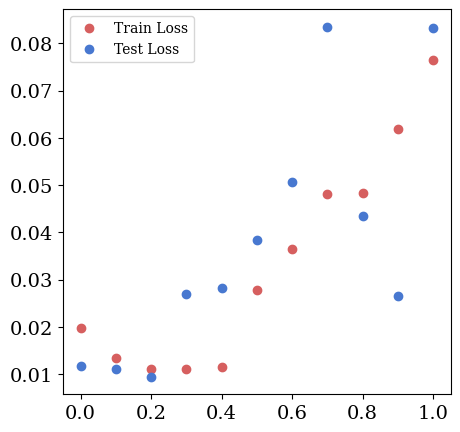

In [29]:
fig, ax = plt.subplots(figsize=(5, 5))
for i, row in df.iterrows():
    interpol_value = row['interpol_value']
    train_loss = row['train_loss']
    test_loss = row['test_loss']
    ax.plot(interpol_value, train_loss, 'ro', label='Train Loss' if i == 0 else "")
    ax.plot(interpol_value, test_loss, 'bo', label='Test Loss' if i == 0 else "")
ax.legend()

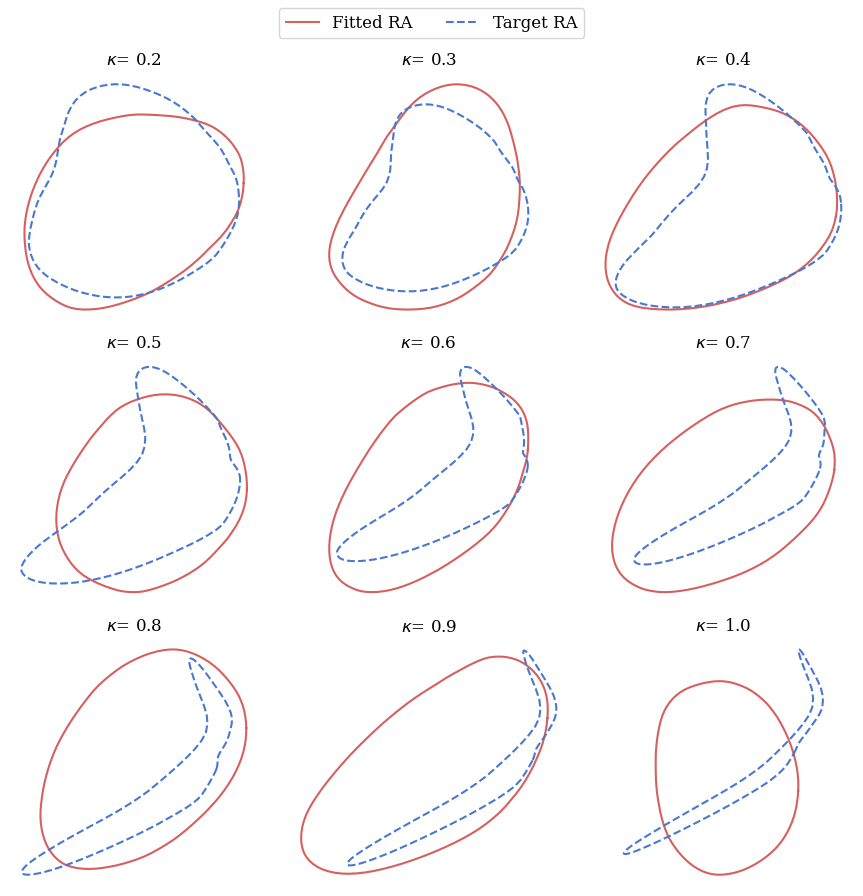

In [30]:
# Select the last 9 entries
last_rows = df.tail(9).reset_index(drop=True)

fig, axes = plt.subplots(3, 3, figsize=(9, 9))
axes = axes.flatten()

for i, (ax, row) in enumerate(zip(axes, last_rows.iterrows())):
    row = row[1]  # iterrows() gives (index, row)

    fit_ra_points = row['fit_ra_points']
    target_ra_points = row['target_ra_points']
    
    ax.plot(fit_ra_points[:, 0], fit_ra_points[:, 1], 'r-', label='Fitted RA')
    ax.plot(target_ra_points[:, 0], target_ra_points[:, 1], 'b--', label='Target RA')
    ax.set_title(f"$\kappa$= {row.interpol_value:.1f}")
    ax.set_aspect('equal')
    ax.axis('off')

# Add a single legend outside the subplots
fig.legend(['Fitted RA', 'Target RA'], loc='upper center', ncol=2, fontsize='large')
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

Vector field perturbation experiment

In [ ]:
maxT = 20
tsteps = maxT*20
simulation_params = {"maxT": maxT, "tsteps": tsteps, "perturbation_norm": 0.01,
    "random_seed": 313, "min_val_sim": 3, "n_grid": 40,
    "add_limit_cycle": False,
    "num_points_invman": 200,
    "number_of_target_trajectories": 30, "initial_conditions_mode": "around_ring", "init_margin": 0.1}
X, Y, U_pert, V_pert, grid_u, grid_v, perturb_grid_u, perturb_grid_v, full_grid_u, full_grid_v, inv_man, trajectories_pertring = build_perturbed_ringattractor(**simulation_params)

trajectories_target = torch.tensor(trajectories_pertring, dtype=torch.float32)
initial_conditions_target = trajectories_target[:, 0, :]
trajectories_target.shape

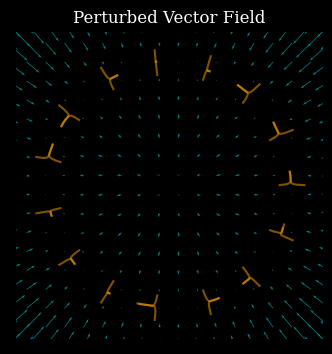

In [ ]:
# Plot the trajectories
plt.rcParams['axes.facecolor'] = 'black'
plt.rcParams['figure.facecolor'] = 'black'
fig, ax = plt.subplots(figsize=(4, 4))
ax.set_aspect('equal')
ax.set_facecolor('black')
ax.set_title('Perturbed Vector Field', color='white')
ax.quiver(X, Y, U_pert, V_pert, color='teal', scale=15, label='Perturbed Vector Field')
for i in range(trajectories_pertring.shape[0]):
    ax.plot(trajectories_pertring[i, :, 0], trajectories_pertring[i, :, 1], color='orange', alpha=0.5)
#ax.plot(inv_man[:,0], inv_man[:,1], color='navy')
min_val_plot = 1.25
ax.set_xlim(-min_val_plot, min_val_plot), ax.set_xticks([])
ax.set_ylim(-min_val_plot, min_val_plot), ax.set_yticks([])
plt.show()

### Train homeomorphism and motif

In [ ]:
dim = 2
dt = simulation_params['maxT'] / simulation_params['tsteps']
time_span = torch.tensor([0.0, simulation_params['maxT']])
# assert int((time_span[1] - time_span[0])/dt) == int(tsteps), "time_span and dt for source do not match the simulation time of target"
# assert int(time_span[1] - time_span[0]) == int(maxT), "time_span and maxT for source do not match the simulation time of target"

homeo_type = 'iresnet'
layer_sizes = 5 * [32]
use_identity_init = True
homeo_params = {'homeo_type': homeo_type, 'dim': dim, 'layer_sizes': layer_sizes, 'use_identity_init': use_identity_init}
homeo_lc = build_homeomorphism(homeo_params)

ds_motif = 'ring' #'lc', 'bla', 'stable', 'square',  
analytic = False
vf_on_ring_enabled = True #if analytic then not used
ds_params = {'ds_motif': ds_motif, 'dim': dim, 'dt': dt, 'time_span': time_span, 'analytic': analytic, 'vf_on_ring_enabled': vf_on_ring_enabled}
source_system_ra = build_ds_motif(**ds_params)
homeo_ds_net = Homeo_DS_Net(homeo_lc, source_system_ra)

lr = 0.00001
num_epochs = 20
annealing_params = {'dynamic': False, 'initial_std': .0, 'final_std': 0.}
training_params = {'lr': lr, 'num_epochs': num_epochs, 'annealing_params': annealing_params, 'early_stopping_patience': 1000, "batch_size": 2}
homeo_ds_net = train_homeo_ds_net(homeo_ds_net=homeo_ds_net, trajectories_target=trajectories_target, **training_params)
homeo_ds_net.training_params = training_params
homeo_ds_net.ds_params = ds_params
homeo_ds_net.homeo_params = homeo_params
homeo_ds_net.eval();
jac_norm = jacobian_norm_over_batch(homeo_lc, trajectories_target.reshape(-1,dim), norm_type='fro', normalize=True)
homeo_ds_net.jac_norm = jac_norm
#save_homeo_ds_net(homeo_ds_networks[0], f"model_pnorm{norm}_irn_.pth")

TypeError: train_homeo_ds_net() got an unexpected keyword argument 'batch_size'

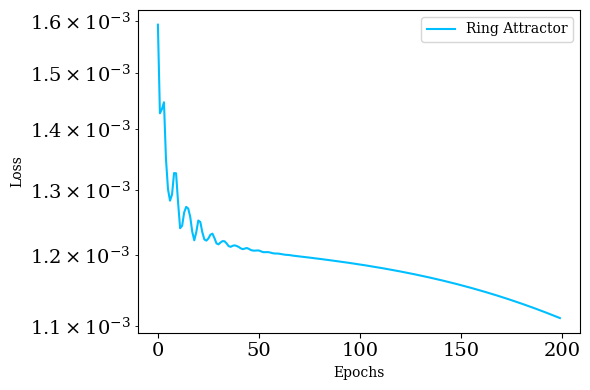

In [ ]:
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
motif_name = 'Ring Attractor'
motif_colors = ["#00BFFF", "#8B008B"]
ax.plot(homeo_ds_net.losses, label=motif_name, color=motif_colors[0])
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
ax.set_yscale('log')
plt.tight_layout()
plt.show()

Losses: -2.9548876142571836


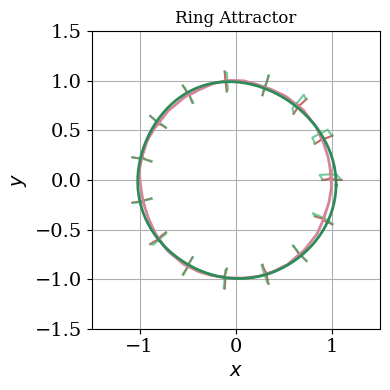

In [ ]:
plot_first_n = simulation_params['number_of_target_trajectories']
trajectories_source, transformed_trajectories, losses = test_single_homeo_ds_net(homeo_ds_net=homeo_ds_net, trajectories_target=trajectories_target)
fit_ra_points = get_homeo_invman(homeo_ds_net.homeo_network)
print(f"Losses: {np.log10(losses)}") 
plot_single_motif_trajectories(trajectories_source=trajectories_source, transformed_trajectories=transformed_trajectories, trajectories_target=trajectories_pertring, num_points=plot_first_n, bounds=(1.5, 1.5), which_axis='second', 
                            asymptotic_target=inv_man, asymptotic_source_transformed=fit_ra_points,
                            source_name='Ring Attractor', show_fig=True,save_name=f"figures/pertring_pnorm{simulation_params['perturbation_norm']}_irn_.pdf")

In [ ]:
#time length generalization
length_factor = 10
maxT_long = maxT/2*length_factor
tsteps_long = (tsteps-15)*length_factor
time_span_long = torch.tensor([0.0, time_span[1]*length_factor])
init_conds_trg = torch.tensor(inv_man, dtype=torch.float32)
trajectories_source_long, transformed_trajectories_long = generate_trajectories_from_initial_conditions(homeo_ds_net, init_conds_trg, time_span_long)

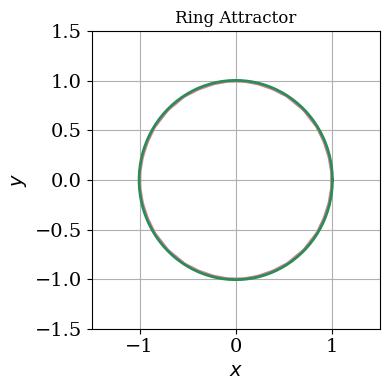

In [ ]:
plot_single_motif_trajectories(trajectories_source_long, transformed_trajectories_long, trajectories_pertring, source_name='Ring Attractor',
                            num_points=init_conds_trg.shape[0], bounds=(1.5, 1.5), which_axis='second', asymptotic_target=inv_man, asymptotic_source_transformed=fit_ra_points)

In [ ]:
#Remarks
# 1. y_0 is inferred well: inv_man == transformed_trajectories_list[0][:,0,:]

# 2. Asymptotic trajectories are not well inferred. nv_man != transformed_trajectories_list[0][:,-1,:]


#But if trained with on-manifold trajectories, then the invariant manifold is well inferred.

## Pertubation experiment

In [ ]:
def run_pert_ra_experiment(
        random_seed=313):
    set_seed(random_seed)
    maxT = 5
    tsteps = maxT*20
    simulation_params = {"maxT": maxT, "tsteps": tsteps, "perturbation_norm": 0.15,
        "random_seed": 313, "min_val_sim": 3, "n_grid": 40,
        "add_limit_cycle": False,
        "num_points_invman": 200,
        "number_of_target_trajectories": 50, "initial_conditions_mode": "random", "init_margin": 0.5}
    
    for p_norm in np.lingspace(0., 0.15, 30):
        simulation_params['perturbation_norm'] = p_norm
        X, Y, U_pert, V_pert, grid_u, grid_v, perturb_grid_u, perturb_grid_v, full_grid_u, full_grid_v, inv_man, trajectories_pertring = build_perturbed_ringattractor(**simulation_params) 
        trajectories_target = torch.tensor(trajectories_pertring, dtype=torch.float32)
        initial_conditions_target = trajectories_target[:, 0, :]

        #init homeo_ds_net


        #train homeo_ds_net


        #test
        #inv_man
        fit_ra_points = get_homeo_ds_net_invman(homeo_ds_net)

        #trained time

        #time length generalization

        #saving
        
    return 0